# Data Processing with BERT

Bert Model Download: https://github.com/google-research/bert#pre-trained-models

inspired by: https://github.com/llSourcell/bert-as-service

DOC: https://bert-as-service.readthedocs.io/en/latest/section/get-start.html#start-the-bert-service

Install BERT:
pip install bert-serving-server
pip install bert-serving-client
Python 3.5 and Tensorflow 1.10 required

Download pretrained model:

https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

add unziped to /tmp/uncased_L-12_H-768_A-12/

then start the service by : bert-serving-start -model_dir /tmp/uncased_L-12_H-768_A-12/ -num_worker=1

In [43]:
from bert_serving.client import BertClient
import pandas as pd
import numpy as np
import h5py
from nltk import tokenize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
news = pd.read_csv('../data/mixed_news/news_dataset.csv')
news = news.dropna(subset=['title','content'])
news = news[news.content != ' ']
news = news[news.title != ' ']

news_train, news_test, label_train, label_test = train_test_split(news[["title","content"]], news["label"], test_size=0.33, 
                                                                  random_state=42)
print(" Train Dataset of size: %i \n Test Dataset of size: %i" % (news_train.shape[0], news_test.shape[0]))
print("Size of FakeNews: %i \n Size of Real News: %i" % (news[news.label == 'fake'].shape[0],news[news.label=="real"].shape[0]))
print("FakeNews Anteil:",len(news[news.label=='fake'])/len(news))
news_train.head()

 Train Dataset of size: 18678 
 Test Dataset of size: 9201
Size of FakeNews: 12167 
 Size of Real News: 15712
FakeNews Anteil: 0.43642167940026544


,title,content
4714,'D**k-Waving Berlusconi Knockoff': Late-Night ...,Share on Twitter \nDuring the third and final ...
2858,Ikea crea un carril rápido para solteros,Ikea crea un carril rápido para solteros LOS C...
25695,Congo forces kill 26 protesters against leader...,Security forces shot dead at least 26 protest...
631,Get Ready For Civil Unrest,Get Ready For Civil Unrest 10/31/2016 \nECONOM...
2028,Review: Brit Bennett’s “The Mothers”,Email \nThe mothers referred to in the title o...


# Vergleichsanalyse:

## Klassifizierung anhand eines Splits:

In [ ]:
text_len_real  =  [len(c) for c in news[news['label']=='real'].content]
plt.hist(text_len_real,color="b", bins=500,density=True,alpha=0.4,label="real")
text_len_fake = [len(c) for c in news[news['label']=='fake'].content]
plt.hist(text_len_fake,color="r",bins=500, density=True,alpha=0.4,label="fake")
plt.xlim(0,20000)
plt.xlabel("Textlänge")
plt.legend()
plt.show()

In [ ]:
data = pd.DataFrame({"x": text_len_fake+text_len_real, "truth": [0]*len(text_len_fake) + [1]*len(text_len_real)})
split=2500
plt.vlines(split,0,0.00025)
plt.hist(text_len_real,color="b", bins=500,density=True,alpha=0.4,label="real")
plt.hist(text_len_fake,color="r",bins=500, density=True,alpha=0.4,label="fake")
plt.xlim(0,20000)
plt.xlabel("Textlänge")
plt.legend()
plt.show()

In [ ]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
data["predict"] = data.x > split
data.head()
from sklearn.metrics import confusion_matrix
data = data.replace(0,"fake").replace(1,"real").replace(False,"fake").replace(True,"real")
plot_confusion_matrix(data.truth,data.predict,["fake","truth"])

# Using BERT for Datapreprocessing
## Encode Titles:

In [ ]:
bc = BertClient()

In [ ]:
train_title_enc = bc.encode(list(news_train['title']))

In [ ]:
with h5py.File('encode_news.h5', 'w') as hf:
    hf.create_dataset("train_title_encode",  train_title_enc)

In [ ]:
test_title_enc = bc.encode(list(news_test['title']))

In [ ]:
with h5py.File('encode_news.h5', 'w') as hf:
    hf.create_dataset("test_title_encode",  test_title_enc)

## Encode Text:

In [ ]:
content = []
num_sentences_train = []
for c in news_train['content']:
    tok = tokenize.sent_tokenize(c)
    content  = content + tok
    num_sentences_train.append(len(tok))

train_content_encode = bc.encode(content)

In [ ]:
with h5py.File('encode_news.h5', 'a') as hf:
    hf.create_dataset("train_content_encode",  data = train_content_encode)
    hf.create_dataset("train_num_sentences", data = np.array(num_sentences_train))

In [ ]:
content = []
num_sentences_test = []
for c in news_test['content']:
    tok = tokenize.sent_tokenize(c)
    content  = content + tok
    num_sentences_test.append(len(tok))

test_content_encode = bc.encode(content)

In [ ]:
with h5py.File('encode_news.h5', 'a') as hf:
    hf.create_dataset("test_content_encode",  data = test_content_encode)
    hf.create_dataset("test_num_sentences", data = np.array(num_sentences_test))

## Read encoded data:

In [14]:
with h5py.File('encoded_data/title_encode.h5', 'r') as hf:
    title_encode = hf['title_encode'][:]
    #text_encode = hf['text_encode'][:]
    #num_sentences = hf['num_sentences'][:]

preparing for NN:

In [20]:
title_NN = pd.DataFrame(data = title_encode)
X_train, X_test, y_train, y_test = train_test_split(title_NN,news.label, test_size=0.33, stratify=news.label,
                                                                  random_state=42)

# Verkleinerung des Designspace mithilfe einer PCA:

In [21]:
modell = PCA()
modell.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

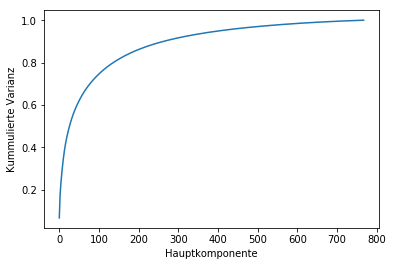

In [22]:
import matplotlib.pyplot as plt
plt.plot(range(768),np.cumsum(modell.explained_variance_ratio_))
plt.xlabel("Hauptkomponente")
plt.ylabel("Kummulierte Varianz")
plt.show()

Es gibt drei Methoden, um zu entscheiden wie viele Hauptkomponenten ausreichend sind:

1. Methode: eine bestimmter prozentsatz der Varainz soll erklärt sein:

In [23]:
print("Anzahl der Hauptkomponenten für erklärte Varianz größer 0.8: ", sum(np.cumsum(modell.explained_variance_ratio_)<0.8)+1)

Anzahl der Hauptkomponenten für erklärte Varianz größer 0.8:  137


2. Methode: Die Hauptkomponenten, die mehr als die mittlere Varianz erkären

In [24]:
print("Anzahl der Hauptkomponenten größer der mittleren erklärten Varainz: ",sum(modell.explained_variance_ratio_ > np.mean(modell.explained_variance_ratio_)))

Anzahl der Hauptkomponenten größer der mittleren erklärten Varainz:  132


Nutzen des Scree-Plots

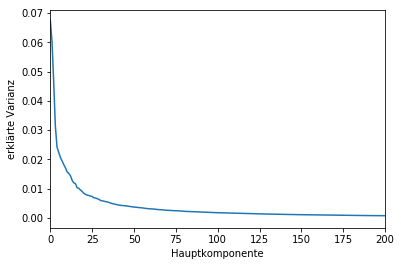

In [25]:
plt.plot(range(768),modell.explained_variance_ratio_)
plt.xlabel("Hauptkomponente")
plt.ylabel("erklärte Varianz")
plt.xlim(0,200)
plt.show()

Der Scree-Plot legt nahe $50-75$ Hauptkomponenten zu nutzen. Ab dann flacht der Graph sehr stark ab

In [53]:
X_train_red = modell.transform(X_train)[:,:130]
X_test_red = modell.transform(X_test)[:,:130]

LE = LabelEncoder()
LE.fit(["fake","real"])
y_train_enc = LE.transform(y_train)
y_test_enc = LE.transform(y_test)

Es werden die ersten 50 Hauptkomponenten weiterverwendet

In [72]:
NN_data_train = pd.DataFrame(X_train_red)
NN_data_train["label"] = y_train_enc
NN_data_test = pd.DataFrame(X_test_red)
NN_data_test["label"] = y_test_enc

NN_data_train.to_hdf('../data/BERT/Bert_title_NN.h5', key='train', mode='w')
NN_data_test.to_hdf('../data/BERT/Bert_title_NN.h5', key='test', mode='a')

/home/larsmoellerherm/.local/anaconda3/lib/python3.7/site-packages/pandas/io/pytables.py:274: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  f(store)


## NN training

In [55]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    plt.savefig("../build/plots/history_bert_title_knn.pdf")
    plt.clf()

seed = 42
rate=0.3
dim = X_train_red.shape[1]

LR = LeakyReLU()
LR.__name__ = 'relu'

model = Sequential()
model.add(Dense(units=dim*10, activation=LR, input_dim=dim))
model.add(Dropout(rate=rate,seed=seed))
model.add(Dense(units=1000, activation='relu'))
model.add(Dropout(rate=rate,seed=seed))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

filepath = '../model/bert_title_nn.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(X_train_red, y_train_enc, validation_split=0.3,
                    epochs=10,batch_size=8, callbacks=[checkpoint, TensorBoard(log_dir='../build/graph',
                                                                                histogram_freq=0, write_graph=True)])
print(history.history.keys())
plot_history(history)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 1300)              170300    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1300)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 1000)              1301000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                10010     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 11        
Total params: 1,481,321
Trainable params: 1,481,321
Non-trainable params: 0
_________________________________________________________________


<Figure size 432x288 with 0 Axes>

9201/9201 [==============================] - 2s 168us/step
[[0.83159566]
 [0.5199023 ]
 [0.9117578 ]
 ...
 [0.8201479 ]
 [0.68173456]
 [0.19044578]] [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [0.]]
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      4016
           1       0.79      0.81      0.80      5185

   micro avg       0.77      0.77      0.77      9201
   macro avg       0.77      0.77      0.77      9201
weighted avg       0.77      0.77      0.77      9201

[[2927 1089]
 [ 983 4202]]


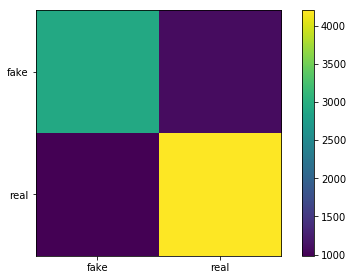

In [57]:
#best_model = load_model('../model/best_bert_title_nn.hdf5')
y_pred = model.predict(X_test_red, batch_size=64, verbose=1)
y_pred_bool = np.round(y_pred)
print(y_pred,y_pred_bool)
print(classification_report(y_test_enc, y_pred_bool))
print(confusion_matrix(y_test_enc, y_pred_bool,
                       labels=[0,1]))
plt.imshow(confusion_matrix(y_test_enc, y_pred_bool,
                            labels=[0,1]))
plt.tight_layout()
plt.colorbar()
plt.xticks(range(2), ["fake", "real"])
plt.yticks(range(2), ["fake", "real"])
plt.savefig("../build/plots/cnfsn_mtx_bert_title_nn.pdf")

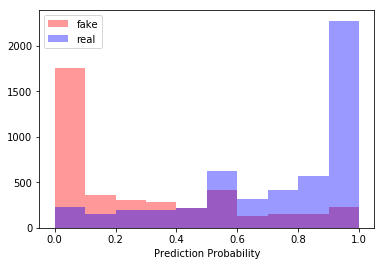

In [68]:
plt.hist(y_pred[y_test_enc == 0],label="fake", alpha = 0.4, color = "r")
plt.hist(y_pred[y_test_enc == 1],label = "real",alpha = 0.4, color = "b")
plt.xlabel("Prediction Probability")
plt.legend()
plt.show()

### ROC Curve:

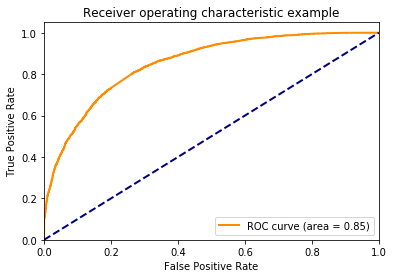

In [67]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test_enc, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()